In [1]:
%matplotlib inline
from IPython.display import display

from openeye import oechem, oeomega, oedepict, oeiupac
import oenotebook as oenb
import cmiles

from fragmenter import chemi
import os
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# Filter mini drug bank
mols = chemi.file_to_oemols('MiniDrugBank_tripos.mol2')
# Count n atoms in mols
n_atoms = [m.NumAtoms() for m in mols]
# Count rotatable bonds in mols
rotatable_bonds = []
for m in mols:
    rot_bonds = 0
    for b in m.GetBonds():
        if b.IsRotor():
            rot_bonds +=1
    rotatable_bonds.append(rot_bonds)

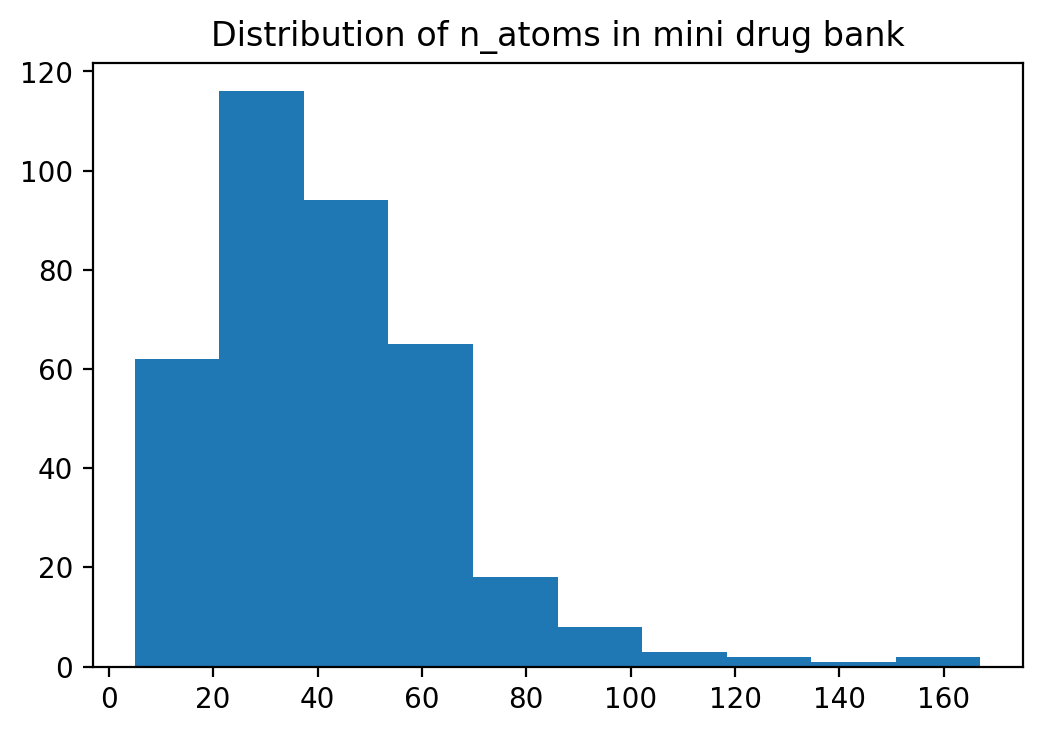

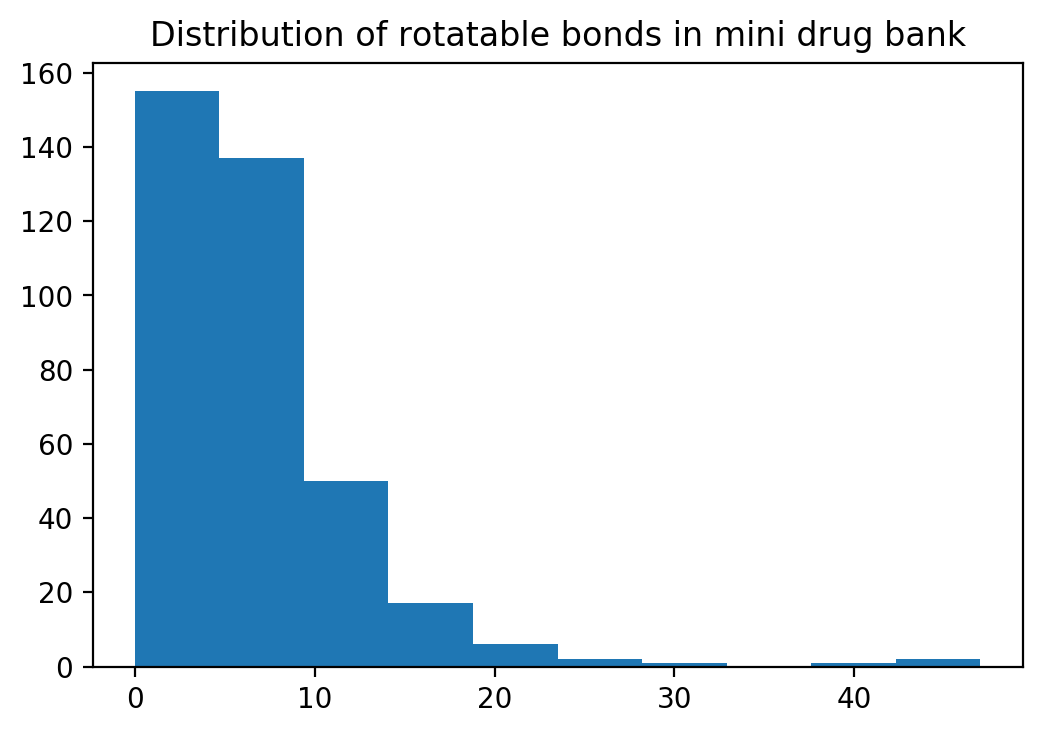

In [3]:
plt.figure(dpi=200)
plt.hist(n_atoms);
plt.title('Distribution of n_atoms in mini drug bank');

plt.figure(dpi=200)
plt.hist(rotatable_bonds);
plt.title('Distribution of rotatable bonds in mini drug bank');

In [4]:
# Figure of all molecules in mini drug bank
chemi.to_pdf(mols, 'mini_drug_bank.pdf')

In [5]:
"""
First stab at filtering
Filter out molecules:
1. > 40 atoms
2. > 8 rotatable bonds and < 3 rotatable bonds
3. Ring systems > 14 atoms
4. Molecules that have longer aliphatic chains (using the [CX4][CX4][CX4][CX4] SMARTS)
"""
def filter_molecules(molecules, num_atoms=40, min_rot_bonds=4, max_rot_bonds=8, ring_sys_size=14, 
                     smarts_patterns=['[CX4][CX4][CX4][CX4]']):
    filtered_mols = []
    for m in molecules:
        keep = True
        if m.NumAtoms() > num_atoms:
            keep = False
        rot_bonds = 0
        for b in m.GetBonds():
            if b.IsRotor():
                rot_bonds +=1
        if rot_bonds > max_rot_bonds or rot_bonds < min_rot_bonds:
            keep = False
        nraromsystems, parts = oechem.OEDetermineRingSystems(m)
        for i in range(1, nraromsystems + 1):
            if len(np.where(np.asanyarray(parts)==i)[0]) > ring_sys_size:
                keep = False
        for smarts in smarts_patterns:
            qmol = oechem.OEQMol()
            if not oechem.OEParseSmarts(qmol, smarts):
                print('OEParseSmarts failed')
            ss = oechem.OESubSearch(qmol)
            oechem.OEPrepareSearch(m, ss)
            match_found = bool(list(ss.Match(m, True)))
            in_ring = False
            for i, match in enumerate(ss.Match(m, True)):
                for ma in match.GetAtoms():
                    in_ring = ma.target.IsInRing()
            if match_found and not in_ring:
                keep = False
        if keep:
            filtered_mols.append(m)
    return filtered_mols


In [6]:
filtered_mols = filter_molecules(mols)
print(len(filtered_mols))
# Filtered mini drug bank
chemi.to_pdf(filtered_mols, 'filtered_mini_drug_bank.pdf')

111


In [7]:
# Filter kinase inhibitor set
# First generate figure of all kinase inhibitors
kinase_inhibitors = chemi.file_to_oemols('../kinase_inhibitors.smi')
chemi.to_pdf(kinase_inhibitors, 'kinase_inhibitors.pdf')

# Filter
filtered_ki = filter_molecules(kinase_inhibitors)
print(len(filtered_ki))
chemi.to_pdf(filtered_ki, 'filtered_kinase_inhibitors.pdf')

27


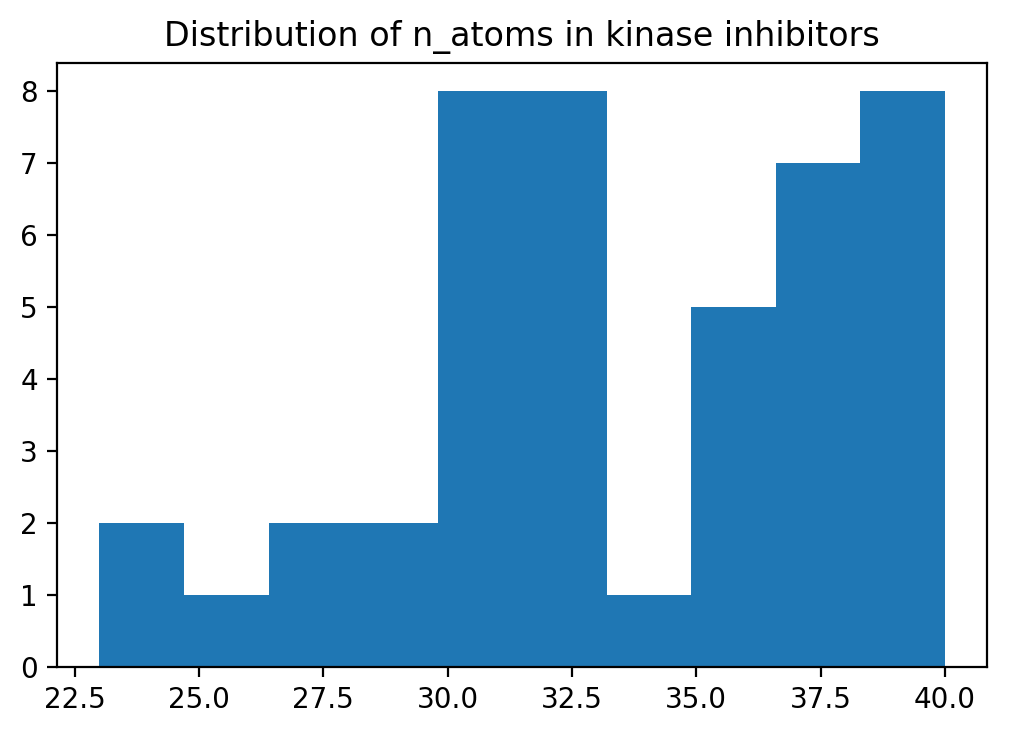

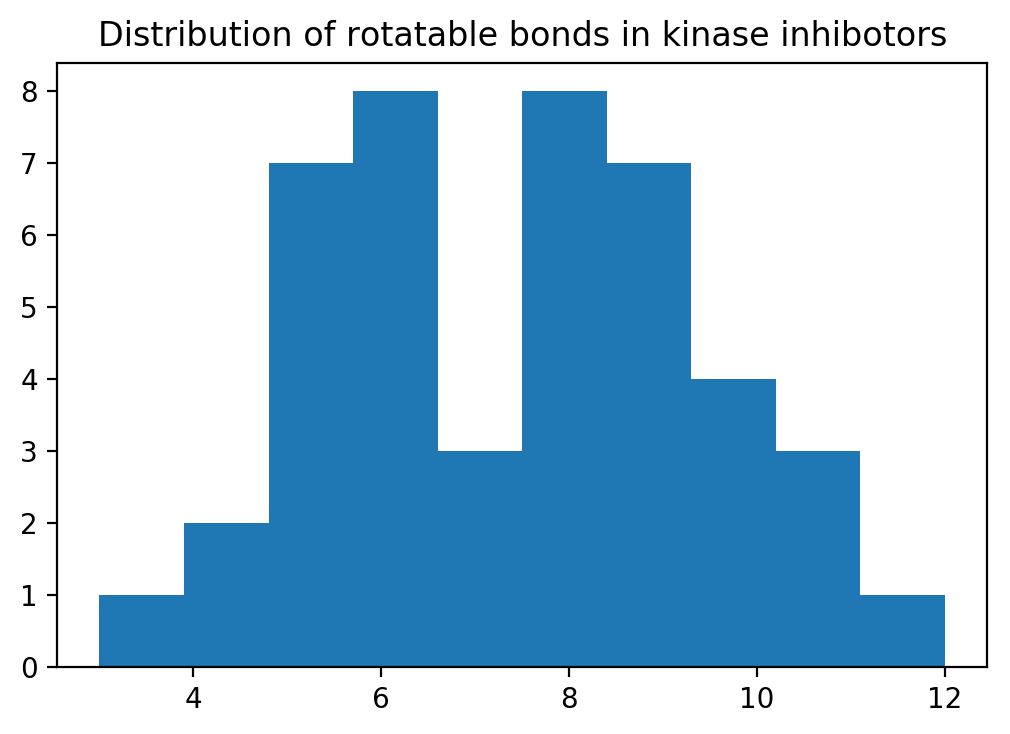

In [8]:
# save kinase inhibitors smi as cmiles ids
n_atoms = [m.NumAtoms() for m in kinase_inhibitors]
# Count rotatable bonds in mols
rotatable_bonds = []
for m in kinase_inhibitors:
    rot_bonds = 0
    for b in m.GetBonds():
        if b.IsRotor():
            rot_bonds +=1
    rotatable_bonds.append(rot_bonds)

plt.figure(dpi=200)
plt.hist(n_atoms);
plt.title('Distribution of n_atoms in kinase inhibitors');

plt.figure(dpi=200)
plt.hist(rotatable_bonds);
plt.title('Distribution of rotatable bonds in kinase inhibotors');

In [9]:
filtered_ki_identifiers = {}
for mol in filtered_ki:
    filtered_ki_identifiers[mol.GetTitle()] = cmiles.to_molecule_id(oechem.OEMolToSmiles(mol), strict=False)

In [10]:
with open('filtered_kinase_inhibitors.json', 'w') as f:
    json.dump(filtered_ki_identifiers, f, indent=2, sort_keys=True)